# Brains4Buildings interactive inverse grey-box analysis pipeline

This Jupyter Labs notebook can be used to interactively test the Brains4Buildings inverse grey-box analysis pipeline.
Don't forget to install the requirements listed in [requirements.txt](../requirements.txt) first!



## Setting the stage

First several imports and variables need to be defined


### Imports and generic settings

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from gekko import GEKKO

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

# usually, two decimals suffice for displaying DataFrames (NB internally, precision may be higher)
pd.options.display.precision = 2

%load_ext autoreload

from virtualdata import Virtualdata 
from inversegreyboxmodel import Learner

%matplotlib inline
%matplotlib widget

from plotter import Plot



### Load Data from Virtual Rooms

In [2]:
%%time

rooms = [
    100010045, 
    100020045, 
    100020180, 
    500010045, 
    500010090 
]

timezone = 'Europe/Amsterdam'
df_prop = pd.DataFrame()

for id in tqdm(rooms):
    df_prop = pd.concat(
        [df_prop,
         Virtualdata.get_virtual_room_data_csv(f'../data/virtualroom_P{id}.zip', timezone)
        ]
    )

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 57 s
Wall time: 58.2 s


In [3]:
df_prop

occupancy__p  co2__ppm  \
id        source timestamp                                           
100010045 model  2022-01-03 00:00:00+01:00             0       415   
                 2022-01-03 00:15:00+01:00             0       415   
                 2022-01-03 00:30:00+01:00             0       415   
                 2022-01-03 00:45:00+01:00             0       415   
                 2022-01-03 01:00:00+01:00             0       415   
...                                                  ...       ...   
500010090 model  2022-01-23 22:45:00+01:00             0       423   
                 2022-01-23 23:00:00+01:00             0       423   
                 2022-01-23 23:15:00+01:00             0       423   
                 2022-01-23 23:30:00+01:00             0       422   
                 2022-01-23 23:45:00+01:00             0       422   

                                            valve_frac__0  
id        source timestamp                                 
100010045 model  2022-01-03 00:00:00+01:00            0.0  
                 2022-01-03 00:15:00+01:00            0.0  
                 2022-01-03 00:30:00+01:00            0.0  
                 2022-01-03 00:45:00+01:00            0.0  
                 2022-01-03 01:00:00+01:00            0.0  
...                                                   ...  
500010090 model  2022-01-23 22:45:00+01:00            0.0  
                 2022-01-23 23:00:00+01:00            0.0  
                 2022-01-23 23:15:00+01:00            0.0  
                 2022-01-23 23:30:00+01:00            0.0  
                 2022-01-23 23:45:00+01:00            0.0  

[10080 rows x 3 columns]

### Convert Virtual Room Property data to preprocessed data

In [12]:
# for firtual room data (with no noise and measurement errors), preprocessing is trivial; just unstack source and prefix source to property name
df_prep = df_prop.unstack([1])
df_prep.columns = df_prep.columns.swaplevel(0,1)
df_prep.columns = ['_'.join(col) for col in df_prep.columns.values]

In [13]:
df_prep

model_occupancy__p  model_co2__ppm  \
id        timestamp                                                       
100010045 2022-01-03 00:00:00+01:00                   0             415   
          2022-01-03 00:15:00+01:00                   0             415   
          2022-01-03 00:30:00+01:00                   0             415   
          2022-01-03 00:45:00+01:00                   0             415   
          2022-01-03 01:00:00+01:00                   0             415   
...                                                 ...             ...   
500010090 2022-01-23 22:45:00+01:00                   0             423   
          2022-01-23 23:00:00+01:00                   0             423   
          2022-01-23 23:15:00+01:00                   0             423   
          2022-01-23 23:30:00+01:00                   0             422   
          2022-01-23 23:45:00+01:00                   0             422   

                                     model_valve_frac__0  
id        timestamp                                       
100010045 2022-01-03 00:00:00+01:00                  0.0  
          2022-01-03 00:15:00+01:00                  0.0  
          2022-01-03 00:30:00+01:00                  0.0  
          2022-01-03 00:45:00+01:00                  0.0  
          2022-01-03 01:00:00+01:00                  0.0  
...                                                  ...  
500010090 2022-01-23 22:45:00+01:00                  0.0  
          2022-01-23 23:00:00+01:00                  0.0  
          2022-01-23 23:15:00+01:00                  0.0  
          2022-01-23 23:30:00+01:00                  0.0  
          2022-01-23 23:45:00+01:00                  0.0  

[10080 rows x 3 columns]

## Learn parameters using inverse grey-box analysis

Most of the heavy lifting is done by the `learn_room_parameters()` function, which again uses the [GEKKO Python](https://machinelearning.byu.edu/) dynamic optimization toolkit.

In [15]:
%%time 
%autoreload 2

# learn the model parameters and write results to a dataframe

df_results, df_prep = Learner.learn_room_parameters(df_prep, ev_type=2)

  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: total: 391 ms
Wall time: 28.3 s


### Result Visualization

In [16]:
df_results

,duration__s,EV_TYPE,vent_min__m3_h_1,vent_max__m3_h_1,actual_room__m3,actual_infilt__cm2,infilt__cm2,mae__ppm,rmse__ppm
id,,,,,,,,,
100010045,1.81e+06,2,10.0,100.0,45.0,9.26,7.26,57.36,75.80
100020045,1.81e+06,2,20.0,100.0,45.0,18.52,9.95,72.49,88.90
100020180,1.81e+06,2,20.0,100.0,180.0,18.52,12.85,37.52,45.14
500010045,1.81e+06,2,10.0,500.0,45.0,9.26,7.51,53.85,72.61
500010090,1.81e+06,2,10.0,500.0,90.0,9.26,8.09,36.12,48.34


In [17]:
df_prep

model_occupancy__p  model_co2__ppm  \
id        timestamp                                                       
100010045 2022-01-03 00:00:00+01:00                   0             415   
          2022-01-03 00:15:00+01:00                   0             415   
          2022-01-03 00:30:00+01:00                   0             415   
          2022-01-03 00:45:00+01:00                   0             415   
          2022-01-03 01:00:00+01:00                   0             415   
...                                                 ...             ...   
500010090 2022-01-23 22:45:00+01:00                   0             423   
          2022-01-23 23:00:00+01:00                   0             423   
          2022-01-23 23:15:00+01:00                   0             423   
          2022-01-23 23:30:00+01:00                   0             422   
          2022-01-23 23:45:00+01:00                   0             422   

                                     model_valve_frac__0 co2_sim__ppm  
id        timestamp                                                    
100010045 2022-01-03 00:00:00+01:00                  0.0        415.0  
          2022-01-03 00:15:00+01:00                  0.0        415.0  
          2022-01-03 00:30:00+01:00                  0.0        415.0  
          2022-01-03 00:45:00+01:00                  0.0        415.0  
          2022-01-03 01:00:00+01:00                  0.0        415.0  
...                                                  ...          ...  
500010090 2022-01-23 22:45:00+01:00                  0.0       428.72  
          2022-01-23 23:00:00+01:00                  0.0        428.4  
          2022-01-23 23:15:00+01:00                  0.0       428.08  
          2022-01-23 23:30:00+01:00                  0.0       427.77  
          2022-01-23 23:45:00+01:00                  0.0       427.47  

[10080 rows x 4 columns]

In [18]:
%autoreload 2
units_to_mathtext = property_types = {
    'degC' : r'$°C$',
    'ppm' : r'$ppm$',
    '0' : r'$[-]$',
    'bool': r'$0 = False; 1 = True$',
    'p' : r'$persons$'
}

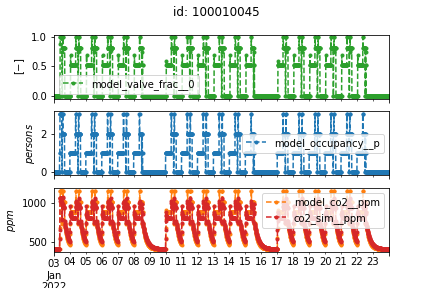

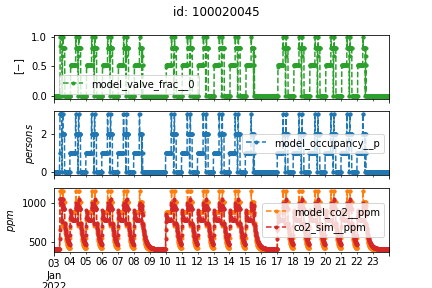

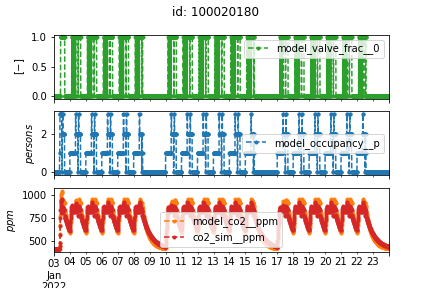

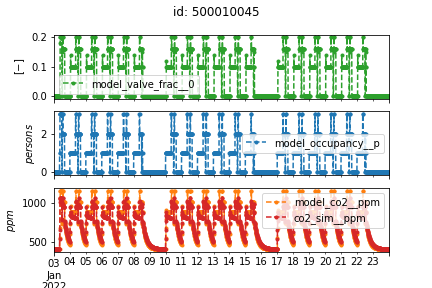

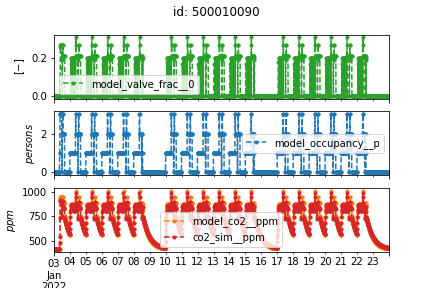

In [19]:
#Plot all properties from all sources for all ids
Plot.dataframe_preprocessed_plot(df_prep, units_to_mathtext)